In [193]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Специальная библиотека для работы с обработкой естественного языка, нам она нужна для анализа настроений
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split

# Импортируем библиотеки для кодирования признаков:
import category_encoders as ce

# для нормализации, стандартизации
from sklearn import preprocessing

# Библиотека для вычислений
from scipy import stats

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Визуальная настройка графиков
sns.set_theme("notebook")

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anzel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [194]:
# фиксируем RANDOM_SEED и версию пакетов
RANDOM_SEED = 42
!pip freeze > requirements.txt

## 1. Загрузка данных и первичное исследование

In [195]:
# Подгрузим наши данные из соревнования

DATA_DIR = 'data/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмиш

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_train, df_test], sort=False).reset_index(drop=True) # объединяем

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

In [196]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1


In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [198]:
df = data.copy()

In [199]:
df.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,sample
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.297672,49.442439,2.823803,0.749999
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.902295,3.466325,4.579425,0.433014
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.625000,48.214662,-0.143372,0.250000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,51.499981,0.010607,1.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233,1.000000


array([[<Axes: title={'center': 'additional_number_of_scoring'}>,
        <Axes: title={'center': 'average_score'}>,
        <Axes: title={'center': 'review_total_negative_word_counts'}>],
       [<Axes: title={'center': 'total_number_of_reviews'}>,
        <Axes: title={'center': 'review_total_positive_word_counts'}>,
        <Axes: title={'center': 'total_number_of_reviews_reviewer_has_given'}>],
       [<Axes: title={'center': 'reviewer_score'}>,
        <Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lng'}>],
       [<Axes: title={'center': 'sample'}>, <Axes: >, <Axes: >]],
      dtype=object)

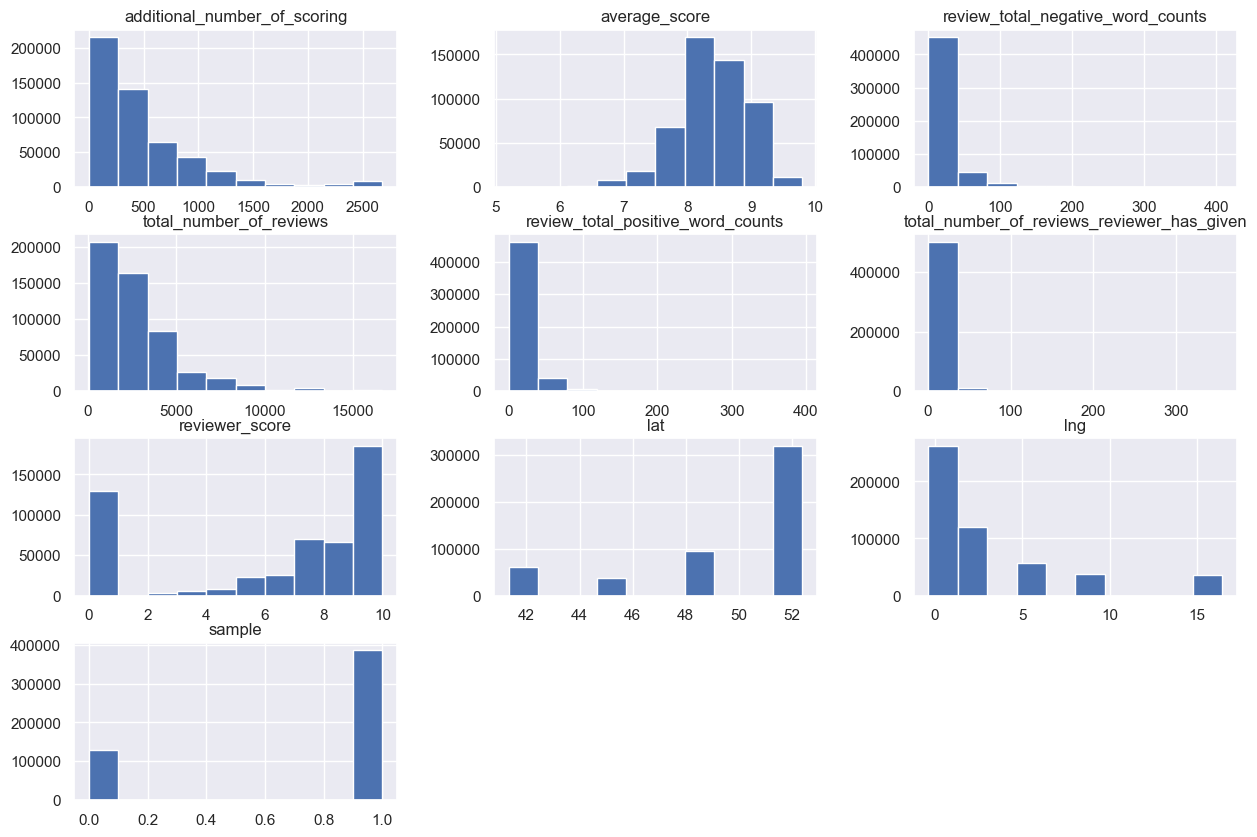

In [200]:
df.hist(figsize=(15,10))

***

Сколько уникальных названий отелей представлено в наборе данных?

In [201]:
df['hotel_name'].unique().shape[0]

1492

Когда был оставлен самый свежий отзыв? Введите ответ в формате yyyy-mm-dd.

In [202]:
df['review_date'] = pd.to_datetime(df['review_date'])

In [203]:
df['review_date'].max()

Timestamp('2017-08-03 00:00:00')

Когда был оставлен самый первый отзыв? Введите ответ в формате yyyy-mm-dd.

In [204]:
df['review_date'].min()

Timestamp('2015-08-04 00:00:00')

Сколько уникальных тегов представлено в наборе данных?

In [205]:
#напишем функцию для создания словаря с тегами
dict_tags = dict()
def func_dict_tags(arg):
    arg = arg[2:-2]
    temp = arg.strip().split(' \', \' ')
    for i in temp:
        if i not in dict_tags:
            dict_tags[i] = 1
        else:
            dict_tags[i] +=1

In [206]:
# создаем словарь с тегами и частотой их употребления
df['tags'].apply(func_dict_tags)

0         None
1         None
2         None
3         None
4         None
          ... 
515733    None
515734    None
515735    None
515736    None
515737    None
Name: tags, Length: 515738, dtype: object

In [207]:
len(dict_tags)

2428

Какой тег представлен в наибольшем числе отзывов?

Из тегов выясните, на сколько ночей чаще всего останавливаются путешественники в отелях.

In [208]:
sorted(dict_tags.items(), key=lambda item: item[1], reverse=True)[0:5]

[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937)]

***

## 2. Очистка данных

### Очистка от дубликатов

In [209]:
#сколько всего дубликатов
df_train.duplicated().sum()

307

Мы не можем удалить дубликаты из общего датасета, зато можем удалить их из тренировочного и затем сформировать новый общий датасет без дубликатов.

In [210]:
# удаляем дубликаты
df_train.drop_duplicates(inplace=True)

In [211]:
#снова объединяем
df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score'] = 0

data = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)

In [212]:
df = data.copy()

### Очистка от пропусков

In [213]:
#сколько всего пропусков и где
df.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
dtype: int64

In [214]:
#у какого количества отелей отсутствуют координаты
null_row = df[df['lat'].isnull() | df['lng'].isnull()][['hotel_name', 'hotel_address']]
null_row.nunique()

hotel_name       17
hotel_address    17
dtype: int64

In [215]:
#названия и адреса отелей с отсутствующими координатами
null_list = null_row.value_counts()
null_list

hotel_name                                        hotel_address                                              
Fleming s Selection Hotel Wien City               Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria    658
Hotel City Central                                Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria            563
Hotel Atlanta                                     W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria       389
Maison Albar Hotel Paris Op ra Diamond            4 rue de la P pini re 8th arr 75008 Paris France               290
Hotel Daniel Vienna                               Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria         245
Hotel Pension Baron am Schottentor                W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria          223
Austria Trend Hotel Schloss Wilhelminenberg Wien  Savoyenstra e 2 16 Ottakring 1160 Vienna Austria               194
Derag Livinghotel Kaiser Franz Joseph Vienna      Sieveringer Stra e 4 

Всего 17 отелей с пропущенными данными, заполним их.

Создадим словарь с координатами каждого из отелей и заменим пустые значения на верные координаты.

In [216]:
coord_dict = {
    'Fleming s Selection Hotel Wien City':[48.209095, 16.354568],
    'Hotel City Central':[48.213560, 16.379923],
    'Hotel Atlanta':[48.220310, 16.355880],
    'Maison Albar Hotel Paris Op ra Diamond':[48.875140, 2.323420],
    'Hotel Daniel Vienna':[48.188835, 16.383810],
    'Hotel Pension Baron am Schottentor':[48.216705, 16.359820],
    'Austria Trend Hotel Schloss Wilhelminenberg Wien':[48.219555, 16.285566],
    'NH Collection Barcelona Podium':[41.391430, 2.177890],
    'Derag Livinghotel Kaiser Franz Joseph Vienna':[48.245914, 16.341188],
    'City Hotel Deutschmeister':[48.220856, 16.366642],
    'Holiday Inn Paris Montmartre':[48.888860, 2.333190],
    'Hotel Park Villa':[48.233495, 16.345556],
    'Cordial Theaterhotel Wien':[48.209530, 16.351515],
    'Roomz Vienna':[48.22201, 16.39331],
    'Mercure Paris Gare Montparnasse':[48.839701, 2.323519],
    'Hotel Advance':[41.38322, 2.16295],
    'Renaissance Barcelona Hotel':[41.392430, 2.167500]
}

In [217]:
df['lat'] = df.apply(lambda x: coord_dict[x['hotel_name']][0] if pd.isnull(x['lat']) else x['lat'], axis=1).astype('float64')
df['lng'] = df.apply(lambda x: coord_dict[x['hotel_name']][1] if pd.isnull(x['lng']) else x['lng'], axis=1).astype('float64')

In [218]:
df[['lat', 'lng']].isnull().sum()

lat    0
lng    0
dtype: int64

## 3. Разведывательный анализ данных

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [220]:
df.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1


### Категориальные признаки

#### 1.hotel_address

Выделим признаки 'город' и 'страна'

In [221]:
df['city'] = df['hotel_address'].apply(lambda x: 'London' if 'United' in x.split()[-2] else x.split()[-2])
df['country'] = df['hotel_address'].apply(lambda x: 'United Kingdom' if 'United' in x.split()[-1] else x.split()[-1])

In [222]:
df['city'].value_counts()

city
London       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: count, dtype: int64

In [223]:
df['country'].value_counts()

country
Kingdom        262300
Spain           60149
France          59626
Netherlands     57212
Austria         38938
Italy           37206
Name: count, dtype: int64

В одной стране по одному городу, удаляем признак города и исходный признак

In [224]:
df.drop('city', axis=1, inplace=True)
df.drop('hotel_address', axis=1, inplace=True)

Закодируем признак страны методом OneHotEncoding

In [225]:
df = pd.get_dummies(df, columns = ['country'], dtype=int)

#### 2.review_date

Выделим месяц

In [226]:
df['review_date'] = pd.to_datetime(df['review_date']) #приводим к формату datetime

In [227]:
df['review_month'] = df['review_date'].dt.month

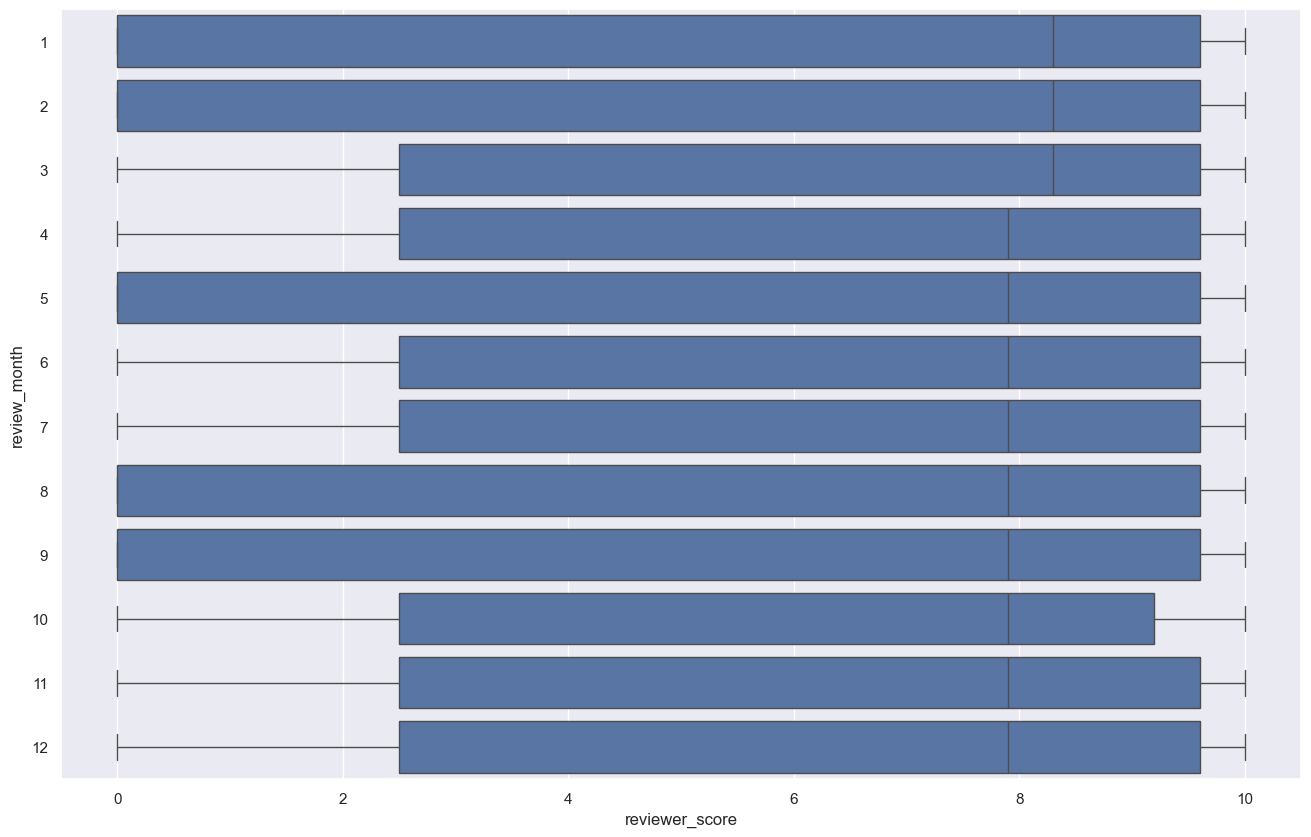

In [228]:
fig = plt.figure(figsize = (16,10))
barplot = sns.boxplot(data=df, x='reviewer_score', y='review_month', orient='h')

Считаю что месяц выделять избыточно потому что почти во всех месяцах медианная оценка одинакова, отличаются только первые три месяца, стоит выделить признак принадлежности к первому кварталу, потому что во 2, 3 и 4 кварталах медианные значения одинаковы.

In [229]:
df['quarter'] = df['review_date'].dt.quarter
df['quarter'] = df['quarter'].apply(lambda x: 1 if x==1 else 0)

In [230]:
# удалим исходный столбец и столбец месяца
df = df.drop(['review_date', 'review_month'], axis=1)

#### 3.hotel_name

Просто удалим его

In [231]:
df = df.drop('hotel_name', axis=1) 

#### 4.reviewer_nationality

Оставим 7 самых распространенных значений

In [233]:
top_7 = df['reviewer_nationality'].value_counts().nlargest(7)

In [234]:
df['reviewer_nationality'] = df['reviewer_nationality'].apply(lambda x: x if x in top_7 else 'other')

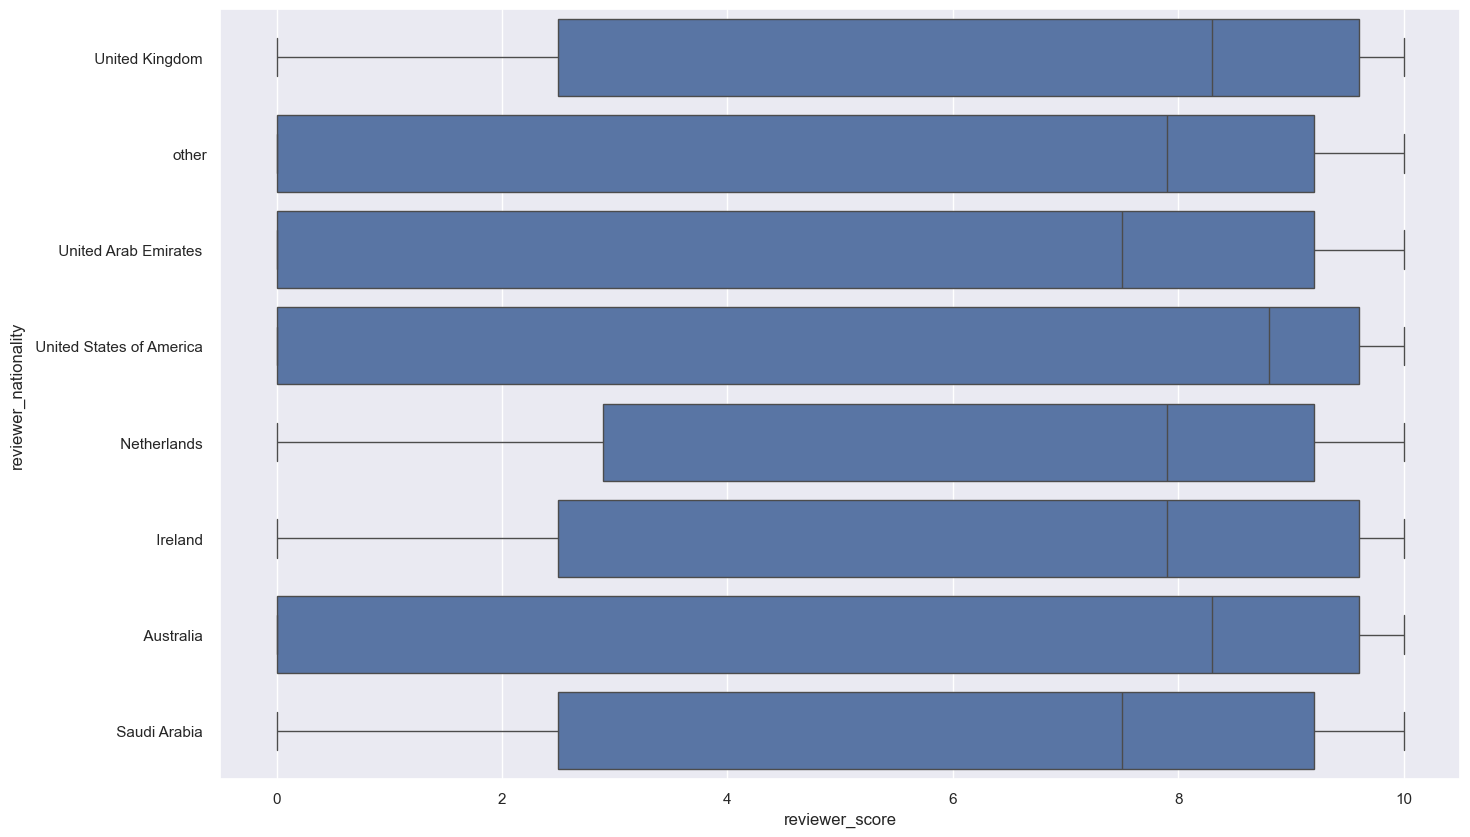

In [235]:
fig = plt.figure(figsize = (16,10))
barplot = sns.boxplot(data=df, x='reviewer_score', y='reviewer_nationality', orient='h')

По графику видно что страна оставившего отзыв имеет влияние на оценку.

In [236]:
# закодируем новый признак
df = pd.get_dummies(df, columns = ['reviewer_nationality'], dtype=int)

#### 5.negative_review

Хотелось бы что-то сделать с признаками количества слов в отзывах, тем более что они сильно влияют на оценку модели. Можно сложить их в один столбец с 0 и 1 в зависимости от длины отзыва. Если позитивный отзыв длиннее ставим 1, в противном случае 0.

Создадим списки самый распространенных слов в отзывах и на их основе создадим новые признаки.

Измерим эмоциональную оценку при помощи SentimentIntensityAnalyzer. В качестве числовой оценки возьмем данные из 'compound'.

In [237]:
# загружаем инструмент оценки
sia = SentimentIntensityAnalyzer()

In [238]:
# создаем столбец с признаком длины отзыва
df['pos_or_neg'] = df.apply(lambda x: 1 if x['review_total_positive_word_counts'] >= x['review_total_negative_word_counts'] else 0, axis=1)

In [239]:
#удаляем безинформационные состояния отзыва
df['negative_review'] = df['negative_review'].apply(lambda x: x.replace("No Negative", ""))

In [240]:
#функция для формирования словаря слов из негативных отзывов
dict_neg = dict()
def func_neg(arg):
    temp = arg.lower().split()
    for i in temp:
        if len(i)>2:
            if i not in dict_neg:
                dict_neg[i] = 1
            else:
                dict_neg[i] +=1
        else:
            continue

In [241]:
#применяем функцию к признаку
df['negative_review'].apply(func_neg)

0         None
1         None
2         None
3         None
4         None
          ... 
515426    None
515427    None
515428    None
515429    None
515430    None
Name: negative_review, Length: 515431, dtype: object

In [242]:
#выводим на экран первые 50 слов, затем вручную отбираем самые значимые
sorted(dict_neg.items(), key=lambda item: item[1], reverse=True)[0:50]

[('the', 531014),
 ('was', 236629),
 ('and', 219362),
 ('room', 175898),
 ('not', 125608),
 ('for', 117584),
 ('very', 80545),
 ('but', 75622),
 ('hotel', 74657),
 ('were', 61654),
 ('had', 60117),
 ('that', 58862),
 ('breakfast', 58440),
 ('have', 54681),
 ('with', 51967),
 ('small', 49857),
 ('there', 46468),
 ('they', 42606),
 ('you', 40567),
 ('from', 40226),
 ('this', 39667),
 ('staff', 39490),
 ('nothing', 38754),
 ('rooms', 34782),
 ('our', 33978),
 ('would', 32278),
 ('could', 32061),
 ('when', 30920),
 ('bed', 29816),
 ('are', 29368),
 ('all', 29117),
 ('too', 28789),
 ('one', 28065),
 ('only', 28024),
 ('bit', 27532),
 ('out', 27034),
 ('bathroom', 26575),
 ('didn', 26445),
 ('which', 26026),
 ('night', 24055),
 ('little', 22527),
 ('like', 22435),
 ('shower', 21285),
 ('good', 20801),
 ('more', 20331),
 ('been', 20315),
 ('did', 20094),
 ('get', 19491),
 ('service', 19313),
 ('bar', 19124)]

In [243]:
#получилось 20 значений
list_neg = ['room', 'very', 'hotel', 'breakfast',
            'small', 'staff', 'nothing', 'rooms',
            'bed', 'all', 'one', 'bit',
            'bathroom', 'night', 'little', 'shower',
            'good', 'more', 'service', 'bar']

In [244]:
#создаем новые признаки на основе сформированного списка
for word in list_neg:
    df['neg_'+word] = df['negative_review'].apply(lambda x: 1 if word in x else 0)

In [245]:
#измеряем эмоциональную оценку
df['negative_sia'] = df['negative_review'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [246]:
#удаляем столбец
df.drop('negative_review', axis=1, inplace=True)

#### 6.positive_review

Повторяем те же действия как и с предыдущим столбцом.

In [247]:
#удаляем безинформационные состояния отзыва
df['positive_review'] = df['positive_review'].apply(lambda x: x.replace("No Positive", ""))

In [248]:
#функция для формирования словаря слов из позитивных отзывов
dict_pos = dict()
def func_pos(arg):
    temp = arg.lower().split()
    for i in temp:
        if len(i)>2:
            if i not in dict_pos:
                dict_pos[i] = 1
            else:
                dict_pos[i] +=1
        else:
            continue

In [249]:
#применяем функцию к признаку
df['positive_review'].apply(func_pos)

0         None
1         None
2         None
3         None
4         None
          ... 
515426    None
515427    None
515428    None
515429    None
515430    None
Name: positive_review, Length: 515431, dtype: object

In [250]:
#выводим на экран первые 50 слов, затем вручную отбираем самые значимые
sorted(dict_pos.items(), key=lambda item: item[1], reverse=True)[0:50]

[('the', 515007),
 ('and', 420393),
 ('was', 236640),
 ('staff', 194472),
 ('location', 192730),
 ('very', 192630),
 ('room', 140673),
 ('hotel', 125259),
 ('good', 112262),
 ('great', 105571),
 ('for', 90996),
 ('were', 90823),
 ('friendly', 85308),
 ('breakfast', 84551),
 ('helpful', 76145),
 ('nice', 69408),
 ('clean', 66890),
 ('with', 65883),
 ('excellent', 62242),
 ('comfortable', 59929),
 ('bed', 49902),
 ('from', 43758),
 ('rooms', 40345),
 ('lovely', 35083),
 ('all', 34525),
 ('you', 32485),
 ('are', 32372),
 ('stay', 32018),
 ('but', 31875),
 ('our', 31696),
 ('close', 30945),
 ('station', 29276),
 ('really', 28215),
 ('had', 28053),
 ('this', 27637),
 ('everything', 27131),
 ('perfect', 25973),
 ('service', 25808),
 ('well', 23757),
 ('not', 23331),
 ('quiet', 21897),
 ('amazing', 21648),
 ('comfy', 21355),
 ('there', 20874),
 ('walk', 20452),
 ('that', 20266),
 ('have', 20099),
 ('bar', 19567),
 ('they', 18859),
 ('would', 18172)]

In [251]:
#получилось 30 значений
list_pos = ['staff', 'location', 'very', 'room',
            'hotel', 'good', 'great', 'friendly',
            'breakfast', 'helpful', 'nice', 'clean',
            'excellent', 'comfortable', 'bed', 'rooms',
            'lovely', 'all', 'stay', 'close',
            'station', 'really', 'perfect', 'service',
            'well', 'quiet', 'amazing', 'comfy',
            'walk', 'bar']

In [252]:
#создаем новые признаки на основе сформированного списка
for word in list_pos:
    df['pos_'+word] = df['positive_review'].apply(lambda x: 1 if word in x else 0)

In [253]:
#измеряем эмоциональную оценку
df['positive_sia'] = df['positive_review'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [254]:
#удаляем столбец
df.drop('positive_review', axis=1, inplace=True)

#### 7.tags

Воспользуемся ранее созданным словарем и создадим 10 признаков на основе 10 самых популярных тегов.

In [255]:
#создаем список из 10 самых популярных тегов
list_tag = dict(sorted(dict_tags.items(), key=lambda x:x[1], reverse=True)[0:10])
list_tag = list(list_tag.keys())

In [256]:
#создаем новые признаки
for tag in list_tag:
    df['tag_'+tag] = df['tags'].apply(lambda x: 1 if tag in x else 0)

In [257]:
df.drop('tags', axis=1, inplace=True)

#### 8.days_since_review

Оставляем только числа.

In [258]:
df['days_since_review'] = df['days_since_review'].apply(lambda x: int(x.split()[0]))

### Числовые признаки. Нормализация

In [259]:
df.nunique()

additional_number_of_scoring          480
average_score                          34
review_total_negative_word_counts     402
total_number_of_reviews              1142
review_total_positive_word_counts     365
                                     ... 
tag_Solo traveler                       2
tag_Stayed 3 nights                     2
tag_Business trip                       2
tag_Group                               2
tag_Family with young children          2
Length: 89, dtype: int64

In [260]:
df.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'days_since_review', 'lat', 'lng', 'sample', 'country_Austria',
       'country_France', 'country_Italy', 'country_Kingdom',
       'country_Netherlands', 'country_Spain', 'quarter',
       'reviewer_nationality_ Australia ', 'reviewer_nationality_ Ireland ',
       'reviewer_nationality_ Netherlands ',
       'reviewer_nationality_ Saudi Arabia ',
       'reviewer_nationality_ United Arab Emirates ',
       'reviewer_nationality_ United Kingdom ',
       'reviewer_nationality_ United States of America ',
       'reviewer_nationality_other', 'pos_or_neg', 'neg_room', 'neg_very',
       'neg_hotel', 'neg_breakfast', 'neg_small', 'neg_staff', 'neg_nothing',
       'neg_rooms', 'neg_bed', 'neg_all', 'neg_one', 'neg_bit', 'neg_bathroom',
       

In [261]:
# числовые признаки
num_cols = ['average_score',
            'additional_number_of_scoring',
            'review_total_negative_word_counts', 
            'total_number_of_reviews',
            'review_total_positive_word_counts',  
            'total_number_of_reviews_reviewer_has_given',
            'lat', 'lng',
            'days_since_review',
            'negative_sia',
            'positive_sia']

In [262]:
# категориальные признаки
cat_cols = ['country_Austria', 'country_France',
            'country_Italy', 'country_Kingdom',
            'country_Netherlands', 'country_Spain',
            'quarter',
            'reviewer_nationality_ Australia ', 'reviewer_nationality_ Ireland ',
            'reviewer_nationality_ Netherlands ', 'reviewer_nationality_ Saudi Arabia ',
            'reviewer_nationality_ United Arab Emirates ', 'reviewer_nationality_ United Kingdom ',
            'reviewer_nationality_ United States of America ', 'reviewer_nationality_other',
            'pos_or_neg',
            'tag_Submitted from a mobile device', 'tag_Leisure trip', 'tag_Couple',
            'tag_Stayed 1 night', 'tag_Stayed 2 nights', 'tag_Solo traveler',
            'tag_Stayed 3 nights', 'tag_Business trip', 'tag_Group',
            'tag_Family with young children',
            'neg_room', 'neg_very', 'neg_hotel', 'neg_breakfast',
            'neg_small', 'neg_staff', 'neg_nothing', 'neg_rooms',
            'neg_bed', 'neg_all', 'neg_one', 'neg_bit',
            'neg_bathroom', 'neg_night', 'neg_little', 'neg_shower',
            'neg_good', 'neg_more', 'neg_service', 'neg_bar',
            'pos_staff', 'pos_location', 'pos_very', 'pos_room', 'pos_hotel',
            'pos_good', 'pos_great', 'pos_friendly', 'pos_breakfast', 'pos_helpful',
            'pos_nice', 'pos_clean', 'pos_excellent', 'pos_comfortable', 'pos_bed',
            'pos_rooms', 'pos_lovely', 'pos_all', 'pos_stay', 'pos_close',
            'pos_station', 'pos_really', 'pos_perfect', 'pos_service', 'pos_well',
            'pos_quiet', 'pos_amazing', 'pos_comfy', 'pos_walk', 'pos_bar']

In [263]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


In [264]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))

При помощи теста Шапиро-Уилка проверим признаки на нормальность:

In [265]:
for i in num_cols:
    print(i)
    result = stats.shapiro(df[i])
    decision_normality(result[1])

average_score
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
additional_number_of_scoring
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
review_total_negative_word_counts
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
total_number_of_reviews
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
review_total_positive_word_counts
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
total_number_of_reviews_reviewer_has_given


C:\Users\anzel\AppData\Local\Temp\ipykernel_10060\1066861282.py:3: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 515431.
  result = stats.shapiro(df[i])


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
lat
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
lng
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
days_since_review
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
negative_sia
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
positive_sia
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Все числовые признаки распределены ненормально. Для их нормализации будем использовать RobustScaler, так как работаем с неочищенными от выбросов данными.

In [266]:
r_scaler = preprocessing.RobustScaler()
df[num_cols] = r_scaler.fit_transform(df[num_cols])

## 4. Отбор признаков

Text(0.5, 1.0, 'Тепловая карта корреляции числовых признаков')

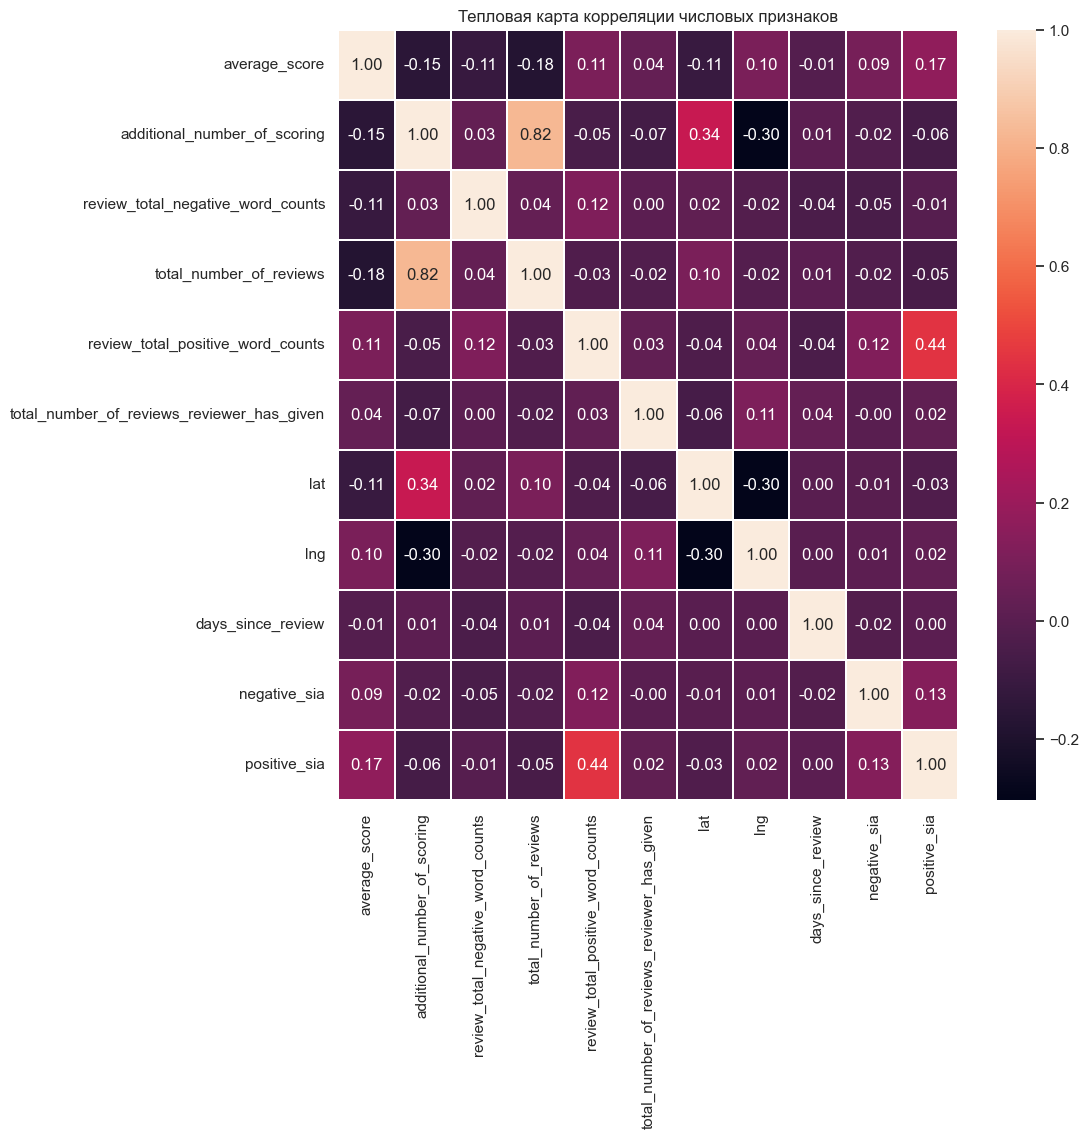

In [267]:
ax = sns.heatmap(df[num_cols].corr(), fmt='.2f', linewidths=.1, annot=True)
ax.set_title('Тепловая карта корреляции числовых признаков')

У двух признаков обнаружена сильная корреляция: 'total_number_of_reviews'(общее количество действительных отзывов об отеле) и 'additional_number_of_scoring'(есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки). 'total_number_of_reviews' выглядит убедительнее, оставляем его а второй удаляем.

In [268]:
df.drop('additional_number_of_scoring', axis=1, inplace=True)

In [269]:
df_corr = df[cat_cols].corr(method = 'spearman')
df_corr.head()

,country_Austria,country_France,country_Italy,country_Kingdom,country_Netherlands,country_Spain,quarter,reviewer_nationality_ Australia,reviewer_nationality_ Ireland,reviewer_nationality_ Netherlands,...,pos_station,pos_really,pos_perfect,pos_service,pos_well,pos_quiet,pos_amazing,pos_comfy,pos_walk,pos_bar
country_Austria,1.000000,-0.103392,-0.079735,-0.290995,-0.101010,-0.103904,-0.018094,0.001591,-0.017993,0.008296,...,0.015226,-0.001496,0.011857,-0.009249,0.003641,1.195798e-02,-0.015713,-0.028365,0.028585,-0.012633
country_France,-0.103392,1.000000,-0.100883,-0.368175,-0.127801,-0.131463,-0.022961,0.041566,-0.014316,0.021651,...,-0.004361,-0.002168,0.019031,-0.003204,0.007176,1.549563e-02,0.000830,-0.017014,0.018882,-0.022845
country_Italy,-0.079735,-0.100883,1.000000,-0.283934,-0.098559,-0.101383,-0.029080,0.041594,-0.020761,0.008381,...,0.068616,-0.002259,0.005099,-0.000888,0.000883,-1.150156e-02,-0.009948,-0.029225,0.016471,-0.011372
country_Kingdom,-0.290995,-0.368175,-0.283934,1.000000,-0.359694,-0.369999,0.050800,-0.049342,-0.012118,-0.051695,...,-0.027990,-0.012339,-0.037668,0.009707,-0.008505,-8.651709e-03,-0.012994,0.039393,-0.055035,-0.010167
country_Netherlands,-0.101010,-0.127801,-0.098559,-0.359694,1.000000,-0.128434,0.013695,-0.011067,0.051151,0.036332,...,0.000833,0.019534,0.006477,-0.003060,0.000052,-1.491131e-07,0.021301,0.020064,0.010660,0.020107


Text(0.5, 1.0, 'Тепловая карта корреляции категориальных признаков')

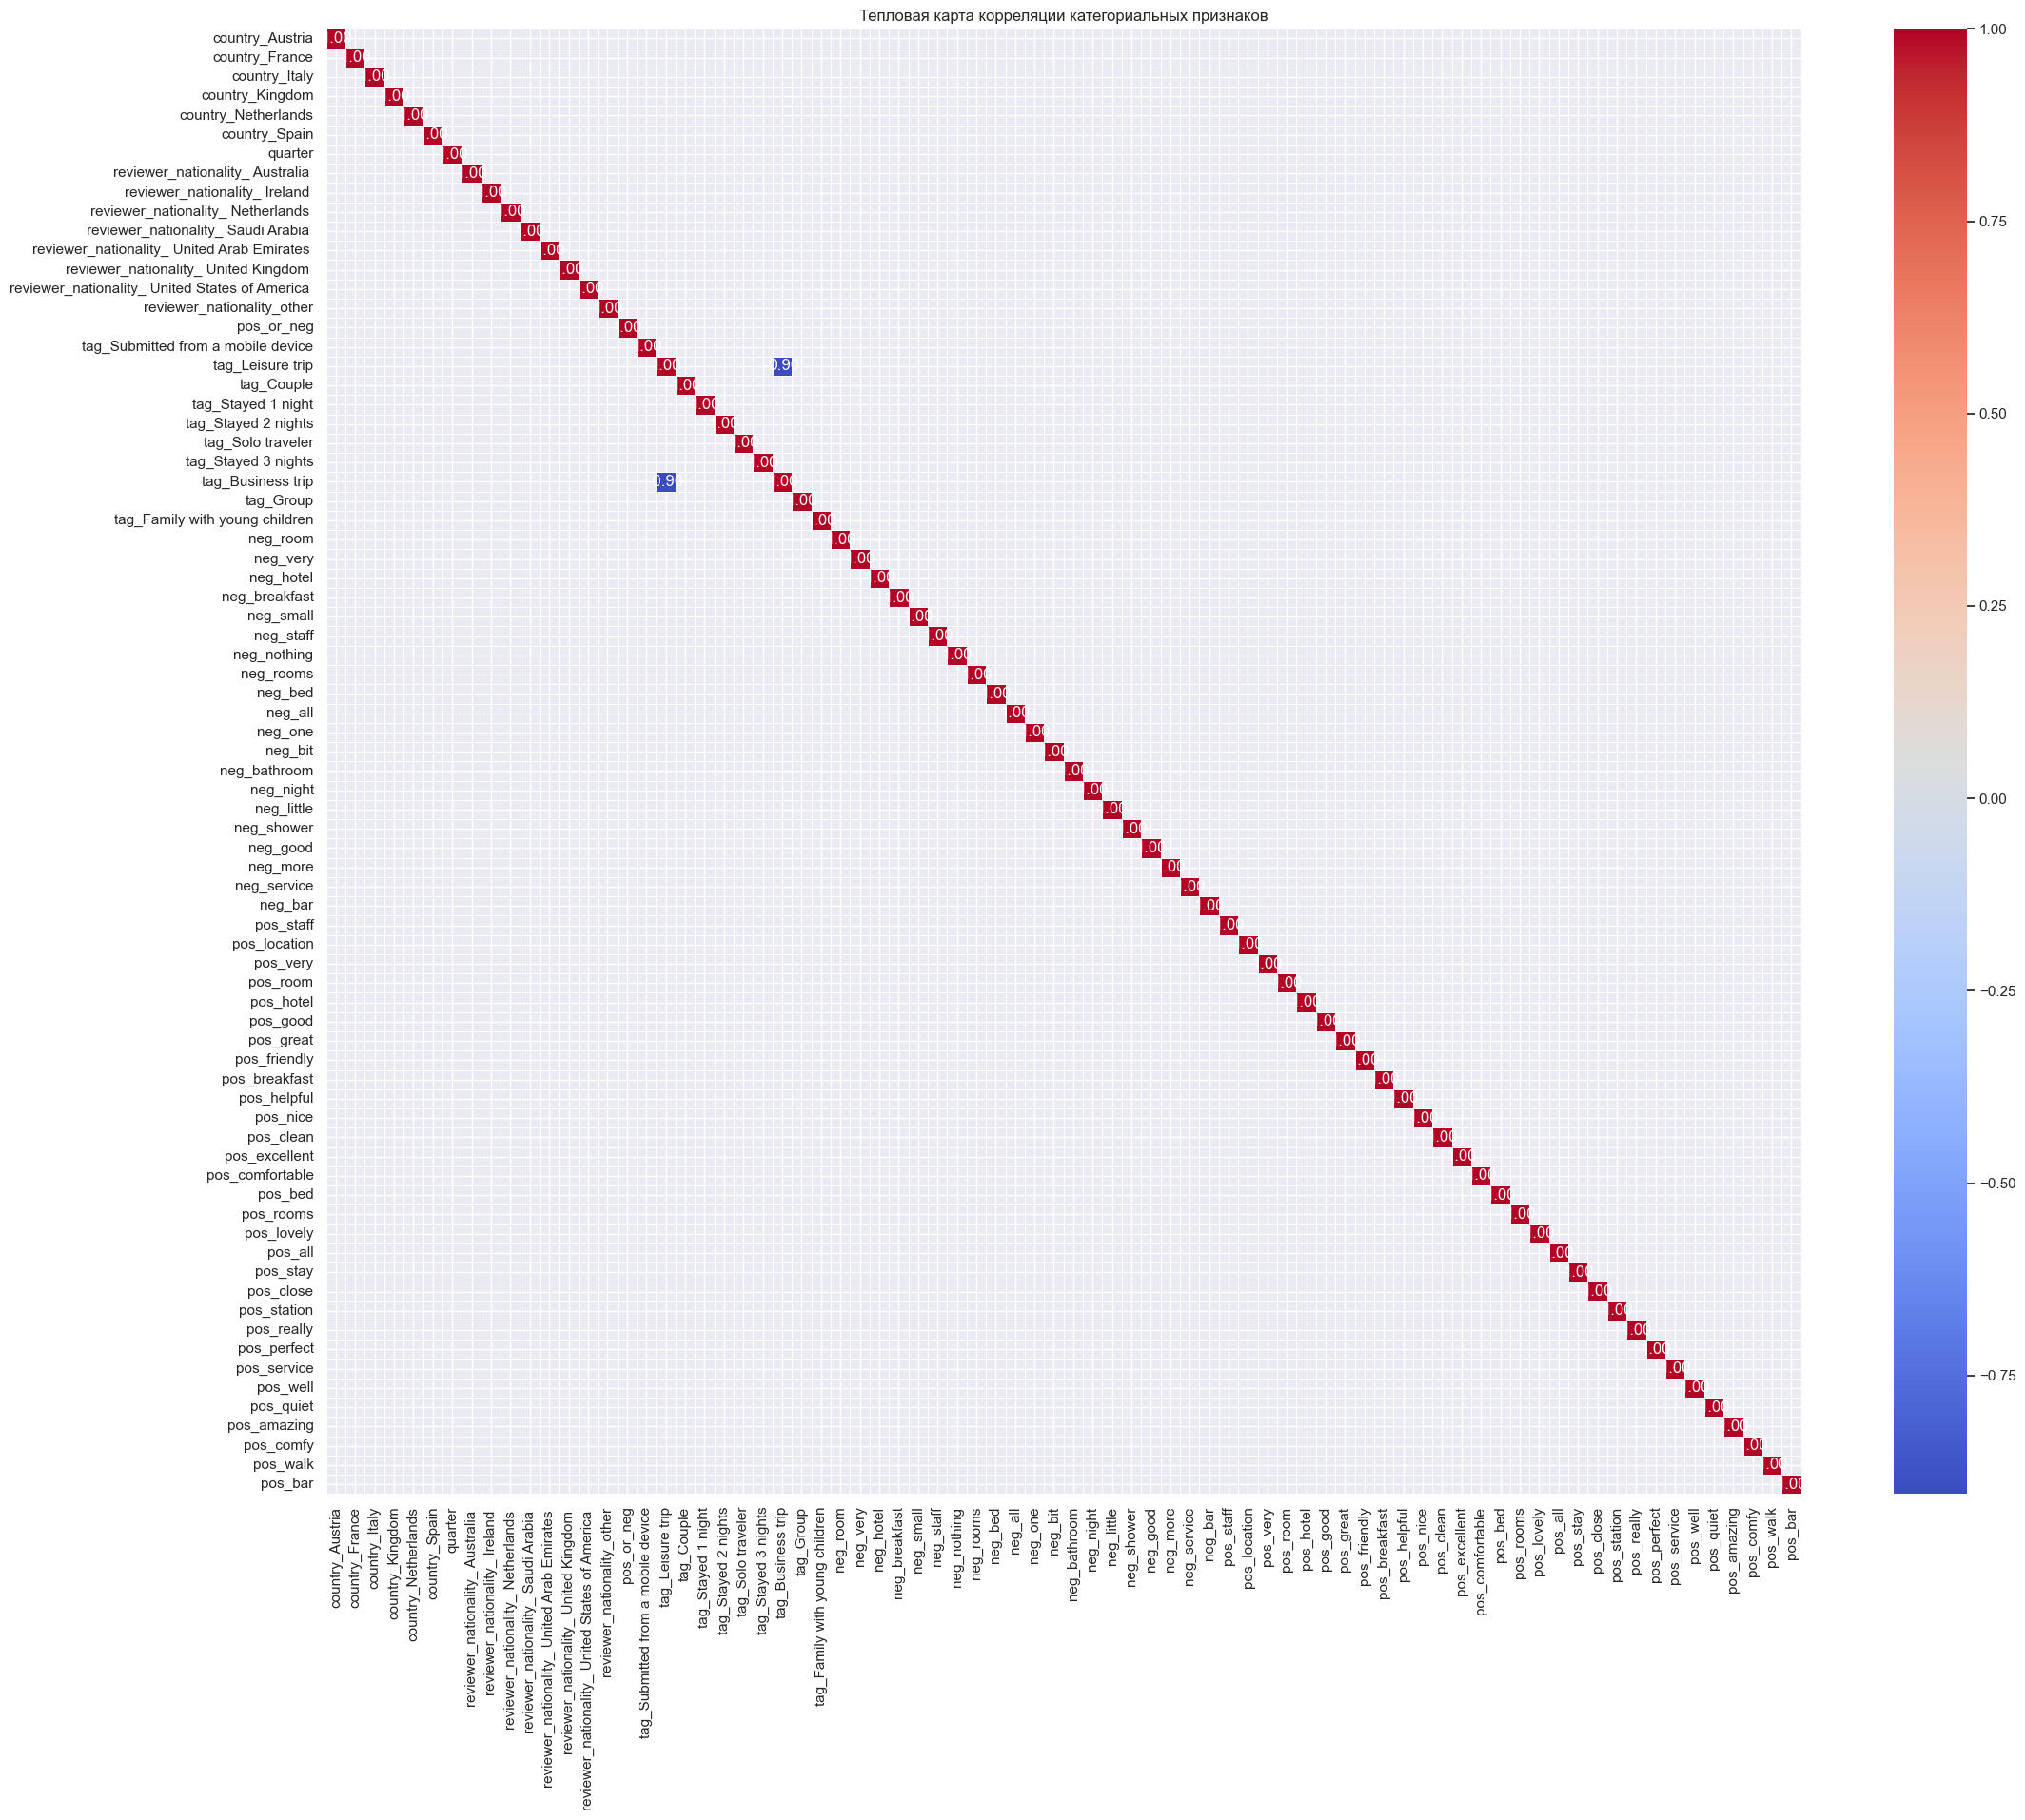

In [270]:
fig = plt.figure(figsize = (25,20))
ax = sns.heatmap(df_corr[0.7<=df_corr.abs()], fmt='.2f', linewidths=.4, cmap='coolwarm', annot=True)
ax.set_title('Тепловая карта корреляции категориальных признаков')

Сильная корреляция между 'tag_Leisure trip' и 'tag_Business trip', удалим первый.

In [271]:
df.drop('tag_Leisure trip', axis=1, inplace=True)

Далее графики важности числовых и категориальных признаков, но исследования показали, что при удалении наименее важных признаков согласно графикам точность модели снижается, поэтому здесь нет отбора признаков на основе графиков важности.

In [285]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

Построим график важности числовых признаков

In [272]:
# числовые признаки
num_cols = ['average_score',
            'review_total_negative_word_counts', 
            'total_number_of_reviews',
            'review_total_positive_word_counts',  
            'total_number_of_reviews_reviewer_has_given',
            'lat', 'lng',
            'days_since_review',
            'negative_sia',
            'positive_sia']

<Axes: >

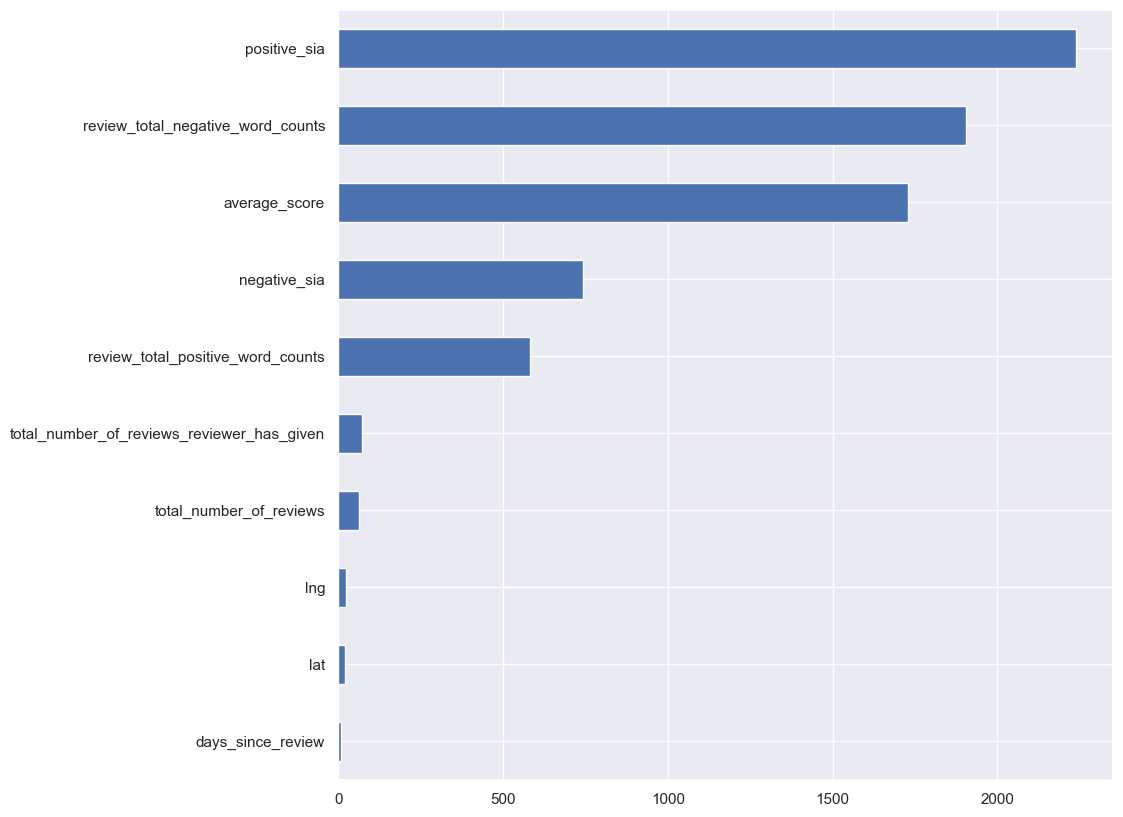

In [273]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Построим график важности категориальных признаков

In [283]:
# категориальные признаки
cat_cols = ['country_Austria', 'country_France',
            'country_Italy', 'country_Kingdom',
            'country_Netherlands', 'country_Spain',
            'quarter',
            'reviewer_nationality_ Australia ', 'reviewer_nationality_ Ireland ',
            'reviewer_nationality_ Netherlands ', 'reviewer_nationality_ Saudi Arabia ',
            'reviewer_nationality_ United Arab Emirates ', 'reviewer_nationality_ United Kingdom ',
            'reviewer_nationality_ United States of America ', 'reviewer_nationality_other',
            'pos_or_neg',
            'tag_Submitted from a mobile device', 'tag_Couple',
            'tag_Stayed 1 night', 'tag_Stayed 2 nights', 'tag_Solo traveler',
            'tag_Stayed 3 nights', 'tag_Business trip', 'tag_Group',
            'tag_Family with young children',
            'neg_room', 'neg_very', 'neg_hotel', 'neg_breakfast',
            'neg_small', 'neg_staff', 'neg_nothing', 'neg_rooms',
            'neg_bed', 'neg_all', 'neg_one', 'neg_bit',
            'neg_bathroom', 'neg_night', 'neg_little', 'neg_shower',
            'neg_good', 'neg_more', 'neg_service', 'neg_bar',
            'pos_staff', 'pos_location', 'pos_very', 'pos_room', 'pos_hotel',
            'pos_good', 'pos_great', 'pos_friendly', 'pos_breakfast', 'pos_helpful',
            'pos_nice', 'pos_clean', 'pos_excellent', 'pos_comfortable', 'pos_bed',
            'pos_rooms', 'pos_lovely', 'pos_all', 'pos_stay', 'pos_close',
            'pos_station', 'pos_really', 'pos_perfect', 'pos_service', 'pos_well',
            'pos_quiet', 'pos_amazing', 'pos_comfy', 'pos_walk', 'pos_bar']

<Axes: >

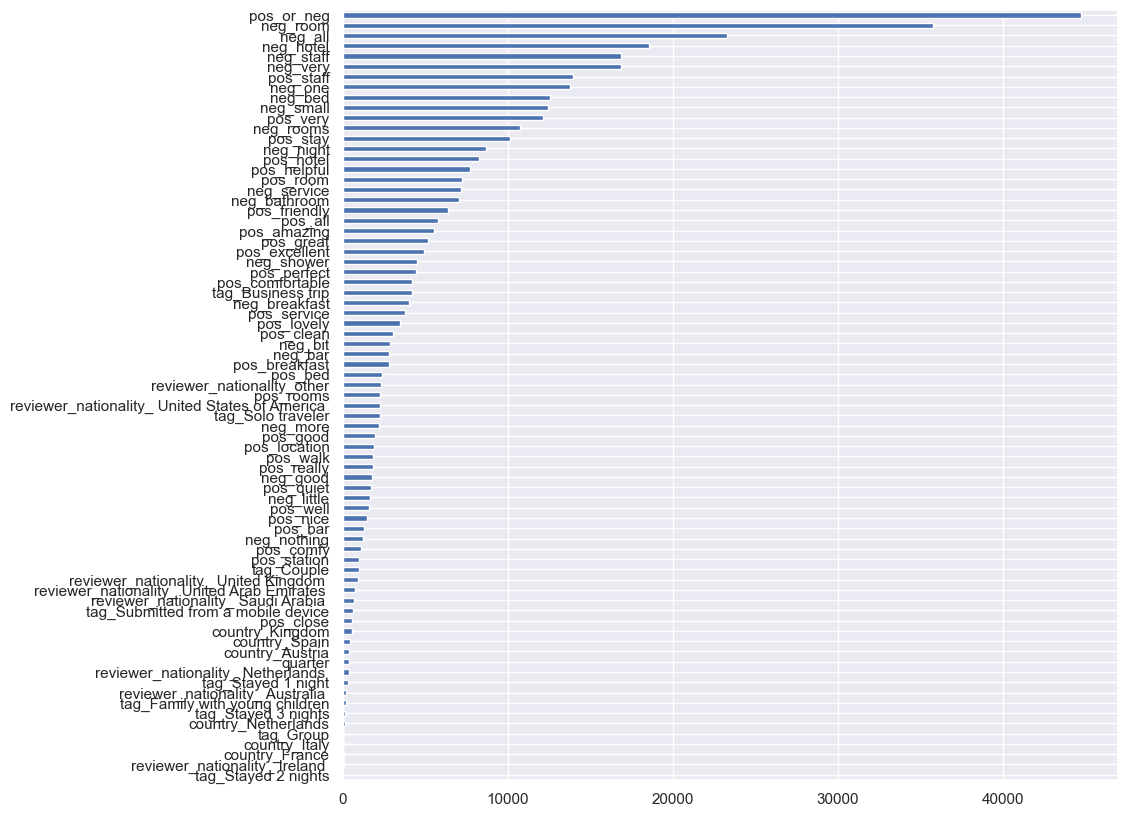

In [284]:
from sklearn.feature_selection import chi2 # хи-квадрат

y=y.astype('int')
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [286]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [287]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 86), (386496, 86), (386496, 85), (309196, 85), (77300, 85))

In [288]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [280]:
#from catboost import CatBoostRegressor
#model = CatBoostRegressor()

In [289]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


In [290]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12051813777256407


<Axes: >

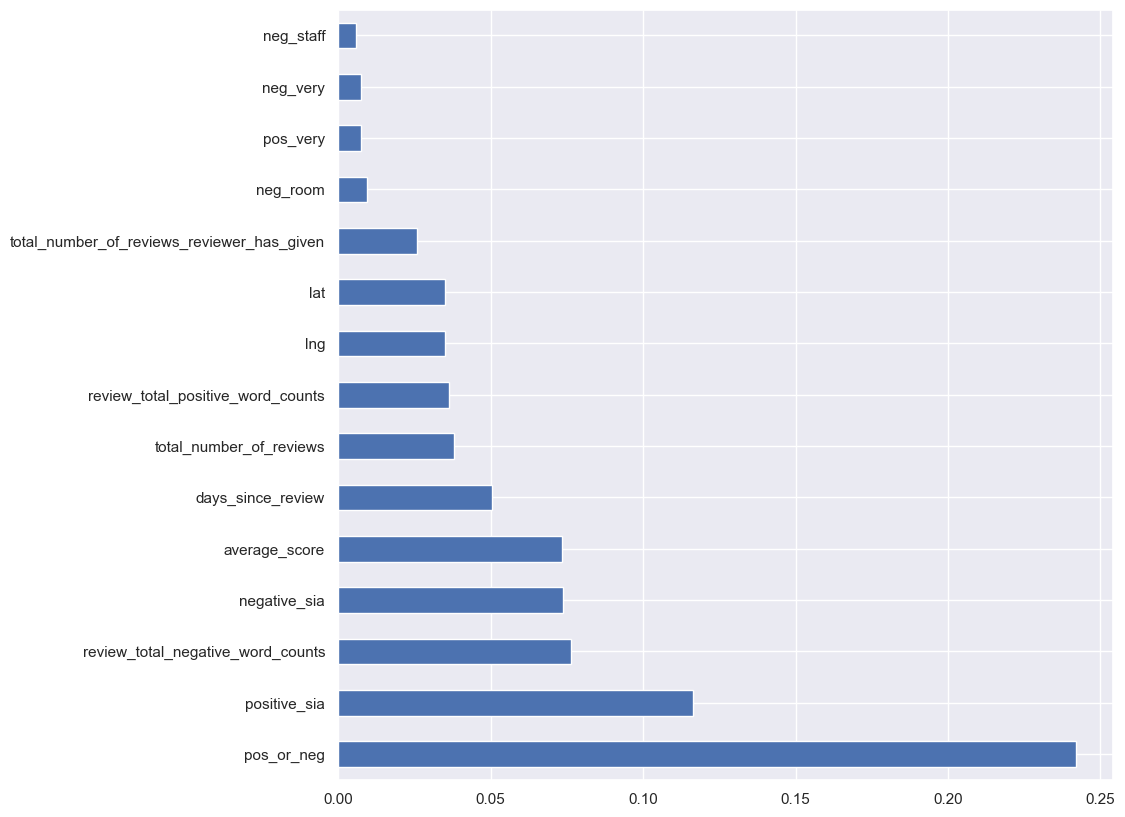

In [291]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [292]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,country_Austria,...,positive_sia,tag_Submitted from a mobile device,tag_Couple,tag_Stayed 1 night,tag_Stayed 2 nights,tag_Solo traveler,tag_Stayed 3 nights,tag_Business trip,tag_Group,tag_Family with young children
433608,0.857143,0.904762,-0.492314,1.117647,2.714286,0.0,-0.889205,-0.998804,3.280373,1,...,0.276276,1,0,0,0,1,1,0,0,0
406744,0.571429,0.285714,-0.030744,2.823529,1.142857,0.0,-0.917614,0.008115,-0.030570,0,...,0.496997,0,1,1,0,0,0,0,0,0
442894,0.714286,-0.142857,-0.493932,-0.117647,1.000000,0.0,-0.394886,-3.061712,0.432303,0,...,0.436937,1,0,0,0,1,0,0,0,0
440167,-0.571429,3.714286,-0.517799,0.588235,-0.285714,0.0,-0.051136,0.259253,0.976207,0,...,0.472598,1,0,0,0,0,0,0,1,0
393564,-0.428571,-0.428571,-0.216019,0.411765,0.285714,0.0,-0.551136,0.004428,-0.033721,0,...,0.117868,1,0,0,0,0,1,0,0,1
508206,0.714286,0.666667,2.012136,2.529412,0.142857,0.0,0.553977,0.246619,0.986836,0,...,-0.652590,0,0,0,1,0,0,0,1,0
442617,0.000000,6.142857,-0.065939,0.117647,-0.285714,0.0,-0.255682,0.261942,0.975838,0,...,0.238551,0,0,0,0,0,1,0,1,0
449526,-0.285714,-0.238095,-0.124191,0.058824,0.857143,0.0,0.738636,-0.005847,-0.005421,0,...,0.425300,0,1,1,0,0,0,0,0,0
402005,0.285714,-0.428571,0.305825,-0.294118,-0.285714,0.0,-0.610795,0.001199,-0.049013,0,...,-0.405781,1,0,1,0,1,0,1,0,0
407839,0.571429,0.095238,2.118528,-0.352941,0.142857,0.0,0.375000,-1.821843,1.842403,0,...,-0.503941,1,1,1,0,0,0,0,0,0


In [293]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [294]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.6s finished


In [295]:
list(sample_submission)

['reviewer_score', 'id']

In [296]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.835,488440
1,7.326,274649
2,8.633,374688
3,9.719,404352
4,9.575,451596
5,8.865,302161
6,7.735,317079
7,7.832,13963
8,8.757,159785
9,7.870,195089
